### LIBRARIES

In [1]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf, adfuller, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 16

### HELPER FUNCTIONS

In [3]:
def check_stationarity(df, ts):
    rolmean = df.rolling(window=12, center=False).mean()
    rolstd = df.rolling(window=12, center=False).std()
    
    plt.figure(figsize=(10,5))

    plt.plot(df, label='ORIGINAL', alpha=0.80)
    plt.plot(rolmean, label='ROLLING MEAN')
    plt.plot(rolstd, label='ROLLING STD')
    plt.legend(loc='best')
    plt.xlabel('Year')
    plt.ylabel('# of Crimes')
    plt.title('Rolling Mean & Standard Deviation for {}'.format(ts))
    plt.grid()
    plt.show(block = False)
    plt.close()
    
    dftest = adfuller(df, autolag='AIC')

    print('Results of Dickey-Fuller Test:\n')
    print('Test Statistic: {}'.format(dftest[0]))
    print('p-value: {}'.format(dftest[1]))
    print('# Lags Used: {}'.format(dftest[2]))
    print('Number of Observations Used: {}'.format(dftest[3]))
    for key, value in dftest[4].items():
        print('Critical Value ({}): {}'.format(key, value))

def evaluate_model_arima(ts, arima_order):
    train = list(ts[0:int(ts.shape[0] * 0.66)].values)
    test = list(ts[int(ts.shape[0] * 0.66):].values)
    history, predictions = train, []

    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0][0]
        predictions.append(yhat)
        history.append(test[t])

    error = mean_squared_error(test, predictions)

    return error


def evaluate_models_arima(ts):
    best_score, best_cfg = np.Inf, None

    for test_order in itertools.product([1, 2, 3, 4], [1], [1, 2, 3, 4]):
        try:
            mse = evaluate_model(ts, test_order)

            if mse < best_score:
                best_score, best_cfg = mse, test_order
                print('ARIMA {} MSE = {}'.format(test_order, mse))
        except:
            continue

    print('Best ARIMA {} MSE = {}'.format(best_cfg, best_score))

def evaluate_model_arma(ts, arma_order):
    train = list(ts[0:int(ts.shape[0] * 0.66)].values)
    test = list(ts[int(ts.shape[0] * 0.66):].values)
    history, predictions = train, []

    for t in range(len(test)):
        model = ARMA(history, order=arma_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0][0]
        predictions.append(yhat)
        history.append(test[t])

    error = mean_squared_error(test, predictions)

    return error

def evaluate_models_arma(ts):
    best_score, best_cfg = np.Inf, None

    for test_order in itertools.product([1, 2, 3, 4], [1, 2, 3, 4]):
        try:
            mse = evaluate_model_arma(ts, test_order)

            if mse < best_score:
                best_score, best_cfg = mse, test_order
                print('ARMA {} MSE = {}'.format(test_order, mse))
        except:
            continue

    print('Best ARMA {} MSE = {}'.format(best_cfg, best_score))

### GENERAL FORECAST: # OF CRIMES PER YEAR OVER THE CITY

#### DATASETS

In [4]:
df = pd.read_csv('../data/time_series/ts_total.csv', index_col='date', 
                 parse_dates=True)
df = df.asfreq('MS')

df.rename(columns={'value': 'ts'}, inplace=True)

#### CHECKING STATIONARITY

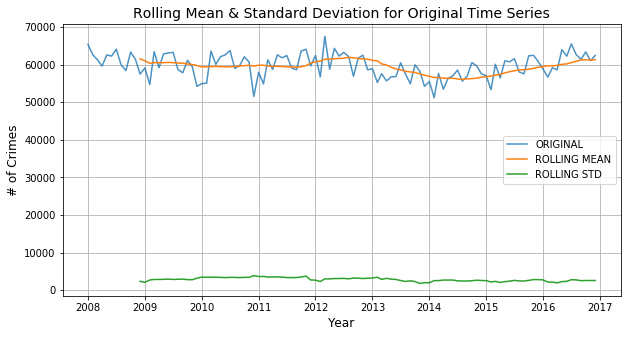

Results of Dickey-Fuller Test:

Test Statistic: -1.440345708582247
p-value: 0.5627884429327581
# Lags Used: 13
Number of Observations Used: 94
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781


In [5]:
check_stationarity(df['ts'], 'Original Time Series')

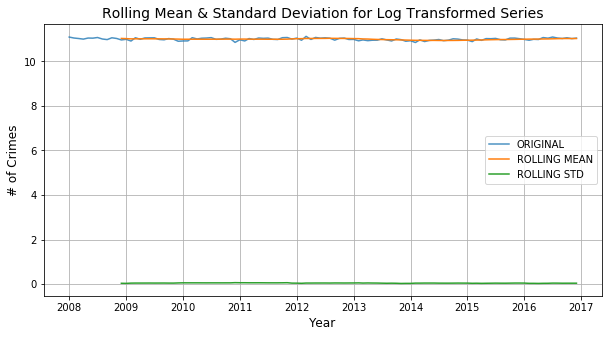

Results of Dickey-Fuller Test:

Test Statistic: -1.431466951406309
p-value: 0.5671009939472946
# Lags Used: 13
Number of Observations Used: 94
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781


In [6]:
ts_log = df['ts'].apply(lambda x: np.log(x))
ts_log_diff = df['ts'].apply(lambda x: np.log(x)).diff(periods=1).dropna()

check_stationarity(ts_log, 'Log Transformed Series')

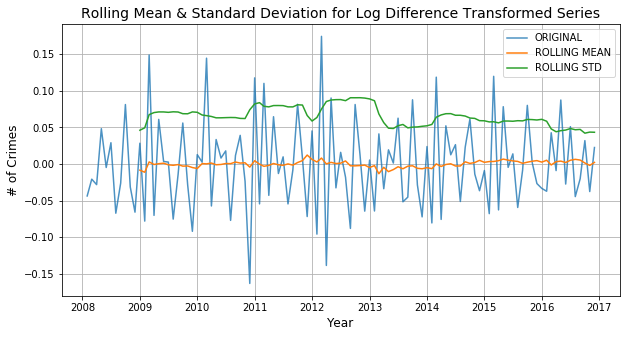

Results of Dickey-Fuller Test:

Test Statistic: -3.4402701898072
p-value: 0.009660312751331937
# Lags Used: 12
Number of Observations Used: 94
Critical Value (1%): -3.5019123847798657
Critical Value (5%): -2.892815255482889
Critical Value (10%): -2.583453861475781


In [7]:
check_stationarity(ts_log_diff, 'Log Difference Transformed Series')

#### VISUALIZATIONS FOR AUTOCORRELATION AND PARTIAL AUTOCORRELATION

In [8]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

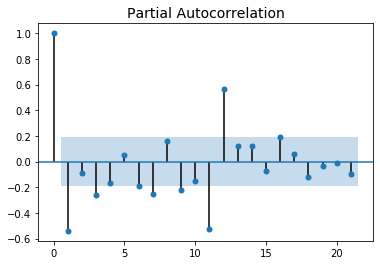

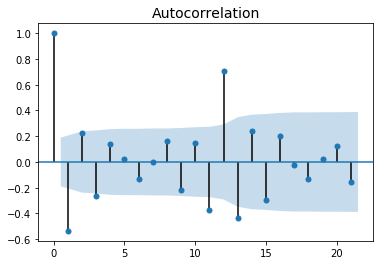

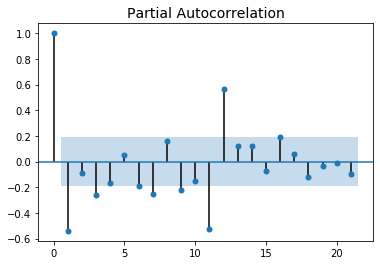

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_diff)
plot_pacf(ts_log_diff)

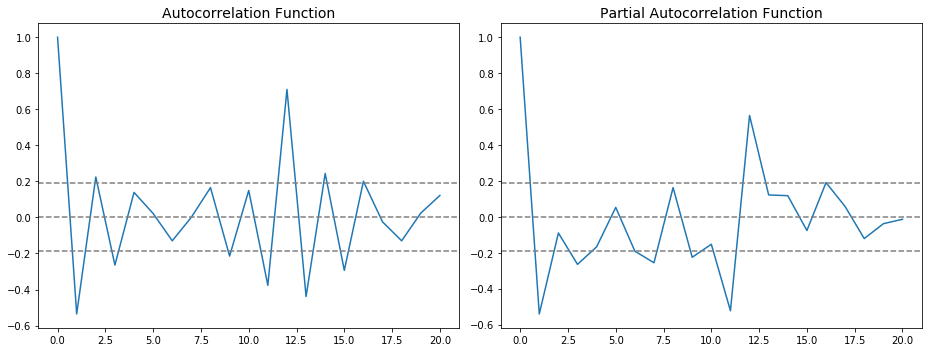

In [10]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### AR MODEL

In [11]:
ar_model_general = AR(ts_log_diff)
results_ar_general = ar_model_general.fit(disp=-1)
one_year_forecast_ar_general = results_ar_general.predict(start=107, end=118)

In [12]:
one_year_forecast_ar_general = \
    np.exp(np.r_[ts_log[-1], one_year_forecast_ar_general.values].cumsum()).astype(int)[1:]

#### ARMA MODEL

In [13]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
    evaluate_models_arma(ts_log_diff)

EVALUATE MODEL?[Y/N] N


In [14]:
arma_model_general = ARMA(ts_log_diff, order=(4, 1))
results_arma_general = arma_model_general.fit(disp=-1)
one_year_forecast_arma_general = results_arma_general.forecast(steps=12)[0]

In [15]:
one_year_forecast_arma_general = \
    np.exp(np.r_[ts_log[-1], one_year_forecast_arma_general].cumsum()).astype(int)[1:]

#### ARIMA MODEL

In [16]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
    evaluate_models(ts_log_diff)

EVALUATE MODEL?[Y/N] N


In [17]:
arima_model_general = ARIMA(ts_log_diff, order=(3, 1, 1))
results_arima_general = arima_model_general.fit(disp=-1)
one_year_forecast_arima_general = results_arima_general.\
    forecast(steps=12)[0]

In [18]:
one_year_forecast_arima_general = \
    np.exp(np.r_[ts_log[-1], one_year_forecast_arima_general].cumsum()).astype(int)[1:]

#### COMPARISON

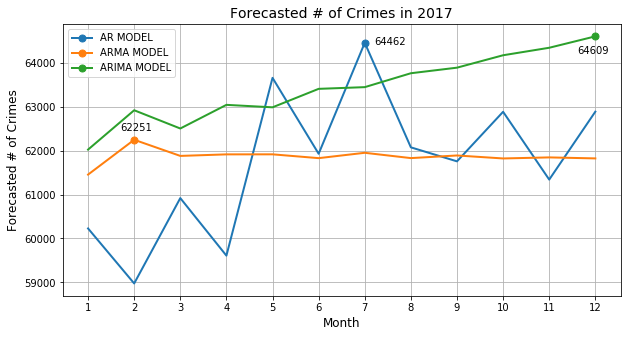

In [19]:
plt.figure(figsize=(10, 5))

plt.plot(range(12), one_year_forecast_ar_general, linewidth=2.0, 
         label='AR MODEL', markersize=7.0, marker='o', markevery=[6])
plt.plot(range(12), one_year_forecast_arma_general, linewidth=2.0, marker='o',
         markersize=7.0, markevery=[1], label='ARMA MODEL')
plt.plot(range(12), one_year_forecast_arima_general, linewidth=2.0, marker='o',
         markersize=7.0, markevery=[11], label='ARIMA MODEL')
plt.annotate(max(one_year_forecast_arima_general), 
             (10.6, max(one_year_forecast_arima_general) - 400))
plt.annotate(max(one_year_forecast_ar_general), 
             (6.2, max(one_year_forecast_ar_general) - 50))
plt.annotate(max(one_year_forecast_arma_general),
             (0.7, max(one_year_forecast_arma_general) + 200))
plt.legend()
plt.xticks(range(12), range(1, 13))
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes in 2017')
plt.grid()
plt.savefig('../imgs/forecasting/general_comparison.pdf', bbox_inches='tight')

### MAJOR CATEGORY FORECAST: # OF CRIMES PER YEAR OVER THE CITY PER MAJOR CATEGORY

#### DATASETS

In [20]:
df = pd.read_csv('../data/time_series/ts_major_cat.csv', index_col='date',
                 parse_dates=True)
cat_dict = {}

for category in df['major_category'].unique():
    cat_dict[category] = df[df['major_category'] == category]
    cat_dict[category] = cat_dict[category].asfreq('MS')
    cat_dict[category].rename(columns={'value': 'ts'}, inplace=True)
    cat_dict[category].drop(columns='major_category', inplace=True)

#### CHECKING STATIONARITY

In [21]:
ts_log_cat = {}
ts_log_diff_cat = {}
ts_log_ewma_cat = {}
ts_log_ewma_diff_cat = {}
ts_moving_avg_cat = {}
ts_log_moving_avg_cat = {}

for category in cat_dict.keys():
    ts_log_cat[category] = cat_dict[category]['ts'].apply(lambda x: np.log(x))
    ts_log_diff_cat[category] = \
        cat_dict[category]['ts'].apply(lambda x: np.log(x)).\
        diff(periods=1).dropna()
    ts_log_ewma_cat[category] = ts_log_cat[category].ewm(halflife=7, ignore_na=False,
                                               min_periods=0, adjust=True).mean()
    ts_log_ewma_diff_cat[category] = ts_log_cat[category] - ts_log_ewma_cat[category]
    ts_moving_avg_cat[category] = cat_dict[category]['ts'].rolling(window=7, center=False).mean().dropna()
    ts_log_moving_avg_cat[category] = ts_log_cat[category].rolling(window=7, center=False).mean().dropna()

In [22]:
for category in cat_dict.keys():
    if category not in ['Fraud or Forgery', 'Sexual Offences']:
        adfuller_results = {}
        
        for ts in ['log', 'log diff', 'ewma', 'ewma diff', 'moving avg', 'log moving avg']:
            to_test = None
                
            if ts == 'log':
                to_test = ts_log_cat
            elif ts == 'log diff':
                to_test = ts_log_diff_cat
            elif ts == 'ewma':
                to_test = ts_log_ewma_cat
            elif ts == 'ewma diff':
                to_test = ts_log_ewma_diff_cat
            elif ts == 'moving avg':
                to_test = ts_moving_avg_cat
            else:
                to_test = ts_log_moving_avg_cat

            dftest = adfuller(to_test[category], autolag='AIC')
            adfuller_results[dftest[1]] = ts

            #print('\nResults of Dickey-Fuller Test for {} and category {}:\n'.format(ts, category))
            #print('Test Statistic: {}'.format(dftest[0]))
            #print('p-value: {}'.format(dftest[1]))
            #print('# Lags Used: {}'.format(dftest[2]))
            #print('Number of Observations Used: {}'.format(dftest[3]))
            #for key, value in dftest[4].items():
                #print('Critical Value ({}): {}'.format(key, value))
            
        min_p_value = min(adfuller_results.keys())
        print('{} minimum p-value {} with {}\n'.
              format(category, min_p_value, adfuller_results[min_p_value]))


Theft and Handling minimum p-value 0.0159808491940031 with ewma

Criminal Damage minimum p-value 0.08137896116016796 with moving avg

Burglary minimum p-value 0.18994573836507256 with log diff

Violence Against the Person minimum p-value 0.24279066991208936 with ewma

Robbery minimum p-value 0.02303026046312816 with ewma

Drugs minimum p-value 0.0010489586334396065 with log diff

Other Notifiable Offences minimum p-value 0.15164837492369004 with log diff



In [23]:
to_forecast = {'Theft and Handling': [ts_log_ewma_cat['Theft and Handling'], 'log ewma'],
               'Criminal Damage': [ts_moving_avg_cat['Criminal Damage'], 'moving avg'],
               'Burglary': [ts_log_diff_cat['Burglary'], 'log diff'],
               'Violence Against the Person': [ts_log_ewma_cat['Violence Against the Person'], 'log ewma'],
               'Robbery': [ts_log_ewma_cat['Robbery'], 'log ewma'],
               'Drugs': [ts_log_diff_cat['Drugs'], 'log diff'],
               'Other Notifiable Offences': [ts_log_diff_cat['Other Notifiable Offences'], 'log diff']}

#### AR MODEL

In [24]:
one_year_forecast_ar_cat = {}

#for category in cat_dict.keys():
#   try:
#        model = AR(ts_log_diff_cat[category])
#        results_ar = model.fit(disp=-1)
#        one_year_forecast_ar_cat[category] = \
#            results_ar.predict(start=107, end=118)
#        one_year_forecast_ar_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_ar_cat[category].values].cumsum()).astype(int)[1:]
#    except:
#        continue

for category in to_forecast.keys():
    s = to_forecast[category][0].shape[0]
    
    model = AR(to_forecast[category][0])
    results_ar = model.fit(disp=-1)
    one_year_forecast_ar_cat[category] = results_ar.predict(start=s, 
                                                            end=s + 11)
        
    if to_forecast[category][1] == 'log diff':
        one_year_forecast_ar_cat[category] = \
            np.exp(np.r_[ts_log_cat[category][-1], 
                         one_year_forecast_ar_cat[category].values].cumsum()).astype(int)[1:]
    elif to_forecast[category][1] == 'log ewma':
        one_year_forecast_ar_cat[category] = \
            np.exp(one_year_forecast_ar_cat[category].values).astype(int)
    else:
        one_year_forecast_ar_cat[category] = \
            one_year_forecast_ar_cat[category].values.astype(int)

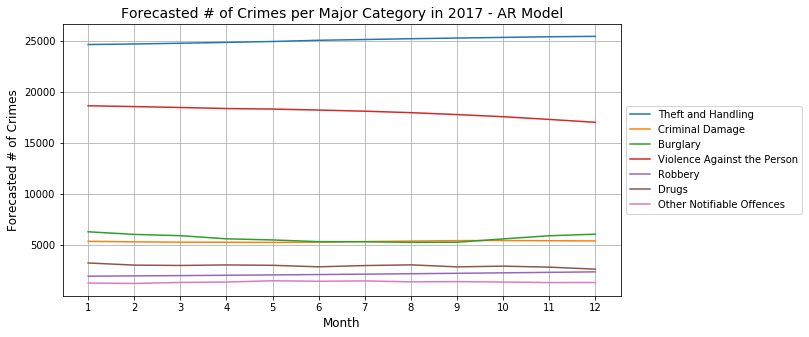

In [25]:
plt.figure(figsize=(10, 5))

for category in one_year_forecast_ar_cat:
    plt.plot(range(12), one_year_forecast_ar_cat[category], label=category)
plt.xticks(range(12), range(1, 13))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Major Category in 2017 - AR Model')
plt.savefig('../imgs/forecasting/major_comparison_ar.pdf', 
            bbox_inches='tight')

#### ARMA MODEL

In [26]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
    for category in to_forecast.keys():
        print()
        print(category)
        
        evaluate_models_arma(to_forecast[category][0])

EVALUATE MODEL?[Y/N] N


In [27]:
validation_arma_cat = {'Theft and Handling': (1, 2),
                       'Criminal Damage': (3, 2),
                       'Burglary': (4, 1),
                       'Robbery': (3, 1),
                       'Drugs': (1, 2),
                       'Other Notifiable Offences': (1, 1)}

In [28]:
one_year_forecast_arma_cat = {}

#for category in cat_dict.keys():
#    try:
#        model = ARMA(ts_log_diff_cat[category], 
#                     order=(1, 1))
#        results_arma = model.fit(disp=-1)
#        one_year_forecast_arma_cat[category] = \
#            results_arma.forecast(steps=12)[0]
#        one_year_forecast_arma_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_arma_cat[category]].cumsum()).astype(int)[1:]
#    except:
#        continue

for category in validation_arma_cat.keys():
    try:
        model = ARMA(to_forecast[category][0], 
                     order=validation_arma_cat[category])
        results_arma = model.fit(disp=-1)
        one_year_forecast_arma_cat[category] = results_arma.forecast(steps=12)[0]

        if to_forecast[category][1] == 'log diff':
            one_year_forecast_arma_cat[category] = \
                np.exp(np.r_[ts_log_cat[category][-1], 
                             one_year_forecast_arma_cat[category]].cumsum()).astype(int)[1:]
        elif to_forecast[category][1] == 'log ewma':
            one_year_forecast_arma_cat[category] = \
                np.exp(one_year_forecast_arma_cat[category]).astype(int)
        else:
            one_year_forecast_arma_cat[category] = \
                one_year_forecast_arma_cat[category].astype(int)
    except:
        print(category)

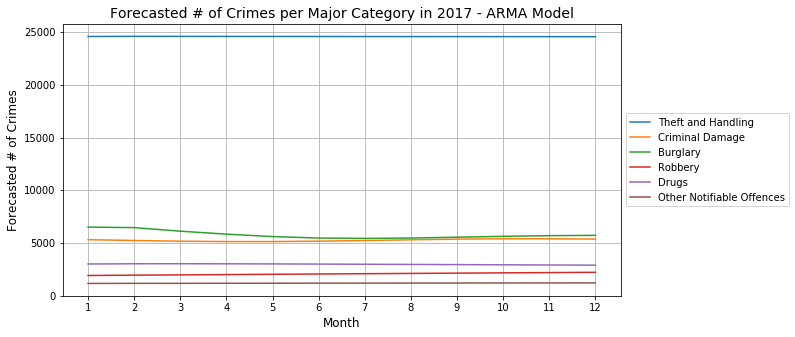

In [29]:
plt.figure(figsize=(10, 5))

for category in one_year_forecast_arma_cat:
    plt.plot(range(12), one_year_forecast_arma_cat[category], label=category)
plt.xticks(range(12), range(1, 13))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Major Category in 2017 - ARMA Model')
plt.savefig('../imgs/forecasting/major_comparison_arma.pdf',
            bbox_inches='tight')

#### ARIMA MODEL

In [30]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
    for category in to_forecast.keys():
        print()
        print(category)

        evaluate_models(to_forecast[category][0])

EVALUATE MODEL?[Y/N] N


In [31]:
validation_arima_cat = {'Theft and Handling': (2, 1, 1),
                        'Criminal Damage': (1, 1, 1),
                        'Burglary': (4, 1, 1),
                        'Violence Against the Person': (4, 1, 2),
                        'Robbery': (3, 1, 3),
                        'Drugs': (2, 1, 1),
                        'Other Notifiable Offences': (2, 1, 1)}

In [32]:
one_year_forecast_arima_cat = {}

#for category in cat_dict.keys():
#    try:
#        model = ARIMA(ts_log_diff_cat[category], 
#                     order=(1, 1, 1))
#        results_arima = model.fit(disp=-1)
#        one_year_forecast_arima_cat[category] = \
#            results_arima.forecast(steps=12)[0]
#        one_year_forecast_arima_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_arima_cat[category]].cumsum()).astype(int)[1:]
#    except:
#        continue

for category in validation_arima_cat.keys():
    try:
        model = ARIMA(to_forecast[category][0], 
                      order=validation_arima_cat[category])
        results_arima = model.fit(disp=-1)
        one_year_forecast_arima_cat[category] = results_arima.forecast(steps=12)[0]

        if to_forecast[category][1] == 'log diff':
            one_year_forecast_arima_cat[category] = \
                np.exp(np.r_[ts_log_cat[category][-1], 
                             one_year_forecast_arima_cat[category]].cumsum()).astype(int)[1:]
        elif to_forecast[category][1] == 'log ewma':
            one_year_forecast_arima_cat[category] = \
                np.exp(one_year_forecast_arima_cat[category]).astype(int)
        else:
            one_year_forecast_arima_cat[category] = \
                one_year_forecast_arima_cat[category].astype(int)
    except:
        print(category)

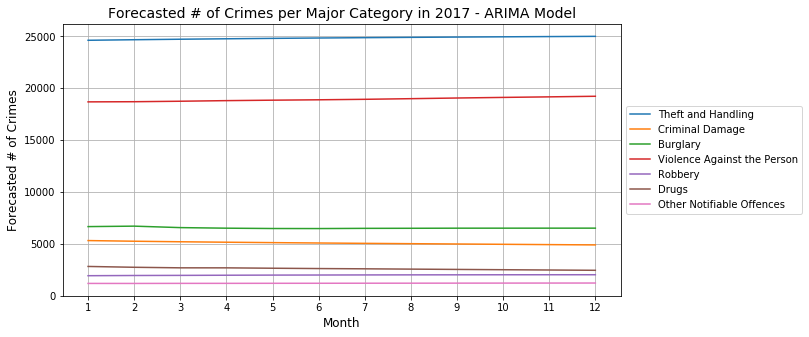

In [33]:
plt.figure(figsize=(10, 5))

for category in one_year_forecast_arima_cat:
    plt.plot(range(12), one_year_forecast_arima_cat[category], label=category)
plt.xticks(range(12), range(1, 13))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Major Category in 2017 - ARIMA Model')
plt.savefig('../imgs/forecasting/major_comparison_arima.pdf',
            bbox_inches='tight')

### BOROUGH CATEGORY FORECAST: # OF CRIMES PER YEAR OVER THE CITY PER BOROUGH

#### DATASETS

In [4]:
df = pd.read_csv('../data/time_series/ts_borough.csv', index_col='date',
                 parse_dates=True)
df.sort_index(inplace=True)

bor_dict = {}

for b in ['Westminster', 'Lambeth', 'Southwark', 'Camden', 'Newham']:
    bor_dict[b] = df[df['borough'] == b]
    bor_dict[b] = bor_dict[b].asfreq('MS')
    bor_dict[b].rename(columns={'value': 'ts'}, inplace=True)
    bor_dict[b].drop(columns=['borough'], inplace=True)

#### CHECKING STATIONARITY

In [5]:
ts_log_bor = {}
ts_log_diff_bor = {}
ts_log_ewma_bor = {}
ts_log_ewma_diff_bor = {}
ts_moving_avg_bor = {}
ts_log_moving_avg_bor = {}

for b in bor_dict.keys():
    ts_log_bor[b] = bor_dict[b]['ts'].apply(lambda x: np.log(x))
    ts_log_diff_bor[b] = \
        bor_dict[b]['ts'].apply(lambda x: np.log(x)).diff(periods=1).dropna()
    ts_log_ewma_bor[b] = ts_log_bor[b].ewm(halflife=7, ignore_na=False,
                                           min_periods=0, adjust=True).mean()
    ts_log_ewma_diff_bor[b] = ts_log_bor[b] - ts_log_ewma_bor[b]
    ts_moving_avg_bor[b] = bor_dict[b]['ts'].rolling(window=7, center=False).mean().dropna()
    ts_log_moving_avg_bor[b] = ts_log_bor[b].rolling(window=7, center=False).mean().dropna()

In [6]:
for b in bor_dict.keys():
    adfuller_results = {}
        
    for ts in ['log', 'log diff', 'ewma', 'ewma diff', 'moving avg', 
               'log moving avg']:
        to_test = None
                
        if ts == 'log':
            to_test = ts_log_bor
        elif ts == 'log diff':
            to_test = ts_log_diff_bor
        elif ts == 'ewma':
            to_test = ts_log_ewma_bor
        elif ts == 'ewma diff':
            to_test = ts_log_ewma_diff_bor
        elif ts == 'moving avg':
            to_test = ts_moving_avg_bor
        else:
            to_test = ts_log_moving_avg_bor

        dftest = adfuller(to_test[b], autolag='AIC')
        adfuller_results[dftest[1]] = ts

            #print('\nResults of Dickey-Fuller Test for {} and category {}:\n'.format(ts, category))
            #print('Test Statistic: {}'.format(dftest[0]))
            #print('p-value: {}'.format(dftest[1]))
            #print('# Lags Used: {}'.format(dftest[2]))
            #print('Number of Observations Used: {}'.format(dftest[3]))
            #for key, value in dftest[4].items():
                #print('Critical Value ({}): {}'.format(key, value))
            
    min_p_value = min(adfuller_results.keys())
    print('{} minimum p-value {} with {}\n'.
          format(b, min_p_value, adfuller_results[min_p_value]))

Westminster minimum p-value 0.08082974753977068 with ewma

Lambeth minimum p-value 3.4452056232443415e-13 with log diff

Southwark minimum p-value 9.736001918960907e-10 with log diff

Camden minimum p-value 0.02001958093576615 with log diff

Newham minimum p-value 3.867543267455588e-12 with ewma diff



In [7]:
to_forecast = {'Westminster': [ts_log_ewma_bor['Westminster'], 'log ewma'],
               'Lambeth': [ts_log_diff_bor['Lambeth'], 'log diff'],
               'Southwark': [ts_log_diff_bor['Southwark'], 'log diff'],
               'Camden': [ts_log_diff_bor['Camden'], 'log diff']}

#### AR MODEL

In [8]:
one_year_forecast_ar_bor = {}

#for category in cat_dict.keys():
#   try:
#        model = AR(ts_log_diff_cat[category])
#        results_ar = model.fit(disp=-1)
#        one_year_forecast_ar_cat[category] = \
#            results_ar.predict(start=107, end=118)
#        one_year_forecast_ar_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_ar_cat[category].values].cumsum()).astype(int)[1:]
#    except:
#        continue

for b in to_forecast.keys():
    s = to_forecast[b][0].shape[0]
    
    model = AR(to_forecast[b][0])
    results_ar = model.fit(disp=-1)
    one_year_forecast_ar_bor[b] = results_ar.predict(start=s, end=s + 11)
            
    if to_forecast[b][1] == 'log diff':
        one_year_forecast_ar_bor[b] = \
            np.exp(np.r_[ts_log_bor[b][-1], 
                         one_year_forecast_ar_bor[b].values].cumsum()).astype(int)[1:]
    else:
        one_year_forecast_ar_bor[b] = \
            np.exp(one_year_forecast_ar_bor[b].values).astype(int)

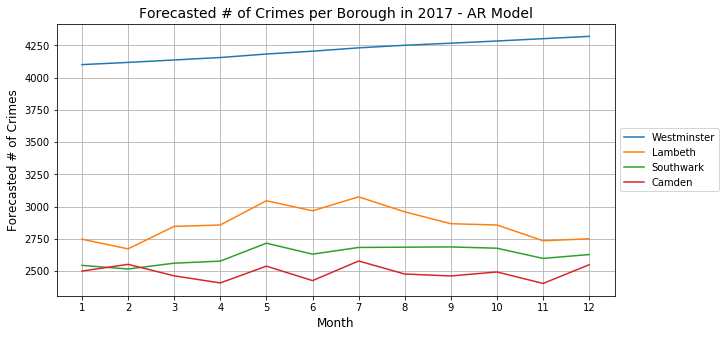

In [9]:
plt.figure(figsize=(10, 5))

for b in one_year_forecast_ar_bor.keys():
    plt.plot(one_year_forecast_ar_bor[b], label=b)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xticks(range(0, 12), range(1, 13))
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Borough in 2017 - AR Model')
plt.savefig('../imgs/forecasting/borough_comparison_ar.pdf', 
            bbox_inches='tight')

#### ARMA MODEL

In [10]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
        for borough in to_forecast.keys():
            print()
            print(borough)

            evaluate_models_arma(to_forecast[borough][0])

EVALUATE MODEL?[Y/N] Y

Westminster
ARMA (1, 1) MSE = 5.362736437214984e-05
ARMA (1, 2) MSE = 4.951964584255955e-05
ARMA (1, 4) MSE = 4.935017613280407e-05
ARMA (2, 1) MSE = 4.1487250140251466e-05
Best ARMA (2, 1) MSE = 4.1487250140251466e-05

Lambeth
ARMA (1, 1) MSE = 0.004370409497009256
ARMA (2, 1) MSE = 0.003952169332622727
ARMA (3, 2) MSE = 0.00392242708879971
Best ARMA (3, 2) MSE = 0.00392242708879971

Southwark
ARMA (1, 1) MSE = 0.003896286009909875
ARMA (3, 2) MSE = 0.0036791409243886186
Best ARMA (3, 2) MSE = 0.0036791409243886186

Camden
ARMA (1, 1) MSE = 0.004132230127742799
ARMA (2, 3) MSE = 0.004026549058777947
Best ARMA (2, 3) MSE = 0.004026549058777947


In [11]:
validation_arma_bor = {'Westminster': (2, 1), 'Lambeth': (3, 2),
                       'Southwark': (3, 2), 'Camden': (2, 3)}

In [12]:
one_year_forecast_arma_bor = {}

#for category in cat_dict.keys():
#    try:
#        model = ARMA(ts_log_diff_cat[category], 
#                     order=(1, 1))
#        results_arma = model.fit(disp=-1)
#        one_year_forecast_arma_cat[category] = \
#            results_arma.forecast(steps=12)[0]
#        one_year_forecast_arma_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_arma_cat[category]].cumsum()).astype(int)[1:]
#    except:
#        continue

for b in validation_arma_bor.keys():
    model = ARMA(to_forecast[b][0], order=validation_arma_bor[b])
    results_arma = model.fit(disp=-1)
    one_year_forecast_arma_bor[b] = results_arma.forecast(steps=12)[0]

    if to_forecast[b][1] == 'log diff':
        one_year_forecast_arma_bor[b] = \
            np.exp(np.r_[ts_log_bor[b][-1], 
                         one_year_forecast_arma_bor[b]].cumsum()).astype(int)[1:]
    else:
        one_year_forecast_arma_bor[b] = \
            np.exp(one_year_forecast_arma_bor[b]).astype(int)

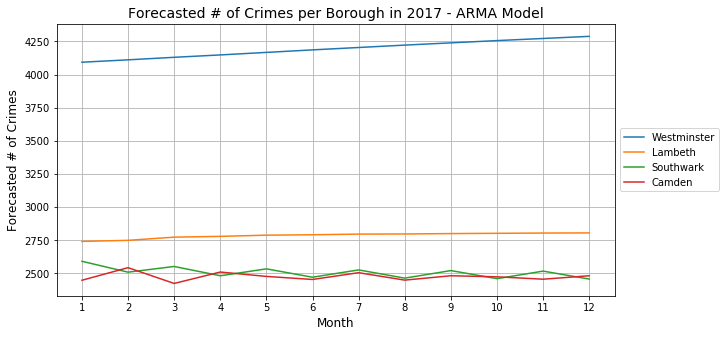

In [13]:
plt.figure(figsize=(10, 5))

for b in one_year_forecast_arma_bor.keys():
    plt.plot(one_year_forecast_arma_bor[b], label=b)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xticks(range(0, 12), range(1, 13))
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Borough in 2017 - ARMA Model')
plt.savefig('../imgs/forecasting/borough_comparison_arma.pdf', 
            bbox_inches='tight')

#### ARIMA MODEL

In [44]:
if input('EVALUATE MODEL?[Y/N] ') == 'Y':
    for borough in to_forecast.keys():
        print()
        print(borough)

        evaluate_models_arima(to_forecast[borough][0])

EVALUATE MODEL?[Y/N] N


In [45]:
one_year_forecast_arima_bor = {}

#for category in cat_dict.keys():
#    try:
#        model = ARMA(ts_log_diff_cat[category], 
#                     order=(1, 1))
#        results_arma = model.fit(disp=-1)
#        one_year_forecast_arma_cat[category] = \
#            results_arma.forecast(steps=12)[0]
#        one_year_forecast_arma_cat[category] = \
#            np.exp(np.r_[ts_log_cat[category][-1], 
#                         one_year_forecast_arma_cat[category]].cumsum()).astype(int)[1:]
#    except:
#        continue

for b in to_forecast.keys():
    model = ARIMA(to_forecast[b][0], order=(2, 1, 2))
    results_arima = model.fit(disp=-1)
    one_year_forecast_arima_bor[b] = results_arima.forecast(steps=37)[0]

    if to_forecast[b][1] == 'log diff':
        one_year_forecast_arima_bor[b] = \
            np.exp(np.r_[ts_log_bor[b][-1], 
                         one_year_forecast_arima_bor[b]].cumsum()).astype(int)[1:]
    else:
        one_year_forecast_arima_bor[b] = \
            np.exp(one_year_forecast_arima_bor[b]).astype(int)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
to_plot = pd.DataFrame(data=one_year_forecast_arima_bor,
                       index=dates)

to_plot.plot(figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Month')
plt.ylabel('Forecasted # of Crimes')
plt.title('Forecasted # of Crimes per Borough from 2017 to 2020 - ARIMA Model')
plt.savefig('../imgs/forecasting/borough_comparison_arima.pdf', 
            bbox_inches='tight')